In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, TextVectorization
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
df = pd.read_csv('../data/df_tokens.csv').drop(columns='Unnamed: 0')
df['Party'] = df['Party'].replace({'Democrat':1, 'Republican':0})
df.head()

,Party,Handle,Tweet,tokens
0,1,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",today senate dems vote savetheinternet proud s...
1,1,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,winterhavensun winter resident alta vista tea...
2,1,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,nbclatino repdarrensoto noted hurricane maria...
3,1,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,nalcabpolicy meeting repdarrensoto thanks tak...
4,1,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,vegalteno hurricane season stas june 1st pueo...


In [3]:
df_lda = pd.read_csv('../data/df_with_lda.csv').drop(columns='Unnamed: 0')
df_lda['Party'] = df_lda['Party'].replace({'Democrat':1, 'Republican':0})
df_lda.head()

/Users/robertherndon/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,Party,Handle,Tweet,tokens,0,1,2,3,4,5,...,10,11,12,13,14,15,16,17,18,19
0,1,RepDarrenSoto,"Today, Senate Dems vote to #SaveTheInternet. P...",today senate dems vote savetheinternet proud s...,0.07,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.85,0.00
1,1,RepDarrenSoto,RT @WinterHavenSun: Winter Haven resident / Al...,winterhavensun winter resident alta vista tea...,0.01,0.01,0.23,0.01,0.01,0.01,...,0.01,0.23,0.01,0.21,0.01,0.01,0.01,0.01,0.01,0.01
2,1,RepDarrenSoto,RT @NBCLatino: .@RepDarrenSoto noted that Hurr...,nbclatino repdarrensoto noted hurricane maria...,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.10,0.01,0.01,0.12,0.01,0.01,0.01,0.01
3,1,RepDarrenSoto,RT @NALCABPolicy: Meeting with @RepDarrenSoto ...,nalcabpolicy meeting repdarrensoto thanks tak...,0.01,0.01,0.01,0.01,0.01,0.86,...,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
4,1,RepDarrenSoto,RT @Vegalteno: Hurricane season starts on June...,vegalteno hurricane season stas june 1st pueo...,0.01,0.01,0.01,0.01,0.01,0.01,...,0.01,0.01,0.01,0.01,0.13,0.13,0.01,0.01,0.01,0.01


In [4]:
# There were 4 NaNs even though there were no NaNs when I saved the .csv
df.dropna(inplace=True)

In [5]:
df.isnull().sum()

Party     0
Handle    0
Tweet     0
tokens    0
dtype: int64

In [6]:
# There were 4 NaNs even though there were no NaNs when I saved the .csv
df_lda.dropna(inplace=True)

In [7]:
df_lda.isnull().sum()

Party     0
Handle    0
Tweet     0
tokens    0
0         0
1         0
2         0
3         0
4         0
5         0
6         0
7         0
8         0
9         0
10        0
11        0
12        0
13        0
14        0
15        0
16        0
17        0
18        0
19        0
dtype: int64

In [8]:
df['Party'] = df['Party'].astype(int)
df['Party']

0        1
1        1
2        1
3        1
4        1
        ..
86456    0
86457    0
86458    0
86459    0
86460    0
Name: Party, Length: 86457, dtype: int64

In [9]:
df_lda['Party'] = df_lda['Party'].astype(int)
df_lda['Party']

0        1
1        1
2        1
3        1
4        1
        ..
86456    0
86457    0
86458    0
86459    0
86460    0
Name: Party, Length: 86457, dtype: int64

# Testing only with Tokens

In [131]:
X = df['tokens']
y = df['Party']

In [132]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [133]:
cvec = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10)

X_train_vec = cvec.fit_transform(X_train)
X_test_vec = cvec.transform(X_test)

In [134]:
y_train.value_counts()

0    33359
1    31483
Name: Party, dtype: int64

In [135]:
X_train_vec.shape, y_train.shape

((64842, 6838), (64842,))

In [159]:
X_test_vec.shape, y_test.shape

((21615, 6838), (21615,))

### Building a stacked model using GridSearch

In [39]:
lr = LogisticRegression(max_iter=10_000)
rf = RandomForestClassifier(n_estimators=200)
gb = GradientBoostingClassifier()

lr_pipe = Pipeline([
    ('lr', lr)
])

rf_pipe = Pipeline([
    ('rf', rf)
])

gb_pipe = Pipeline([
    ('gb', gb)
])

In [40]:
lr_params = {
    'lr__penalty': ['l2'],
    'lr__C': [0.001,0.01,0.1,1,10,100],
    'lr__class_weight': ['balanced', None]
}
lr_gs = GridSearchCV(lr_pipe, param_grid=lr_params)
lr_gs.fit(X_train_vec, y_train)
print(lr_gs.best_score_)
lr_gs.best_params_

0.7692082586344916


{'lr__C': 1, 'lr__class_weight': None, 'lr__penalty': 'l2'}

In [41]:
rf_params = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 30, 40, 50],
    'rf__min_samples_leaf': [1, 2, 3],
    'rf__min_samples_split': [2, 3, 4, 5] 
}
rf_gs = GridSearchCV(rf_pipe, param_grid=rf_params)
rf_gs.fit(X_train_vec, y_train)
print(rf_gs.best_score_)
rf_gs.best_params_

0.7443478110308028


{'rf__max_depth': None,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 4,
 'rf__n_estimators': 200}

In [42]:
gb_params = {
    'gb__learning_rate': [.1, .2, .3, .4],
    'gb__n_estimators': [100, 150, 200, 250],
    'gb__max_depth': [2, 3, 4, 5]
}
gb_gs = GridSearchCV(gb_pipe, param_grid=gb_params)
gb_gs.fit(X_train_vec, y_train)
print(gb_gs.best_score_)
gb_gs.best_params_

0.7429906954604272


{'gb__learning_rate': 0.4, 'gb__max_depth': 5, 'gb__n_estimators': 250}

In [136]:
from sklearn.ensemble import StackingClassifier

level_1_models = [         
    ('lr_pipe', Pipeline([
        ('lr', LogisticRegression(C=1, class_weight=None, penalty='l2', max_iter=10_000, solver='lbfgs'))
    ])),
    ('rf_pipe', Pipeline([
        ('rf', RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=200))
    ])),
    ('gb_pipe', Pipeline([
        ('gb', GradientBoostingClassifier(learning_rate=.4, max_depth=5, n_estimators=250))
    ]))]
    
stack = StackingClassifier(estimators=level_1_models, final_estimator=LogisticRegression())

In [138]:
cross_val_score(stack, X_train_vec, y_train).mean()

0.7748527904224134

In [139]:
stack.fit(X_train_vec, y_train);
stack.score(X_train_vec, y_train), stack.score(X_test_vec, y_test)

(0.8966873322846304, 0.7782095766828592)

In [157]:
X_test_vec.shape, y_test.shape

((21615, 6838), (21615,))

ValueError: X has 6838 features per sample; expecting 3616

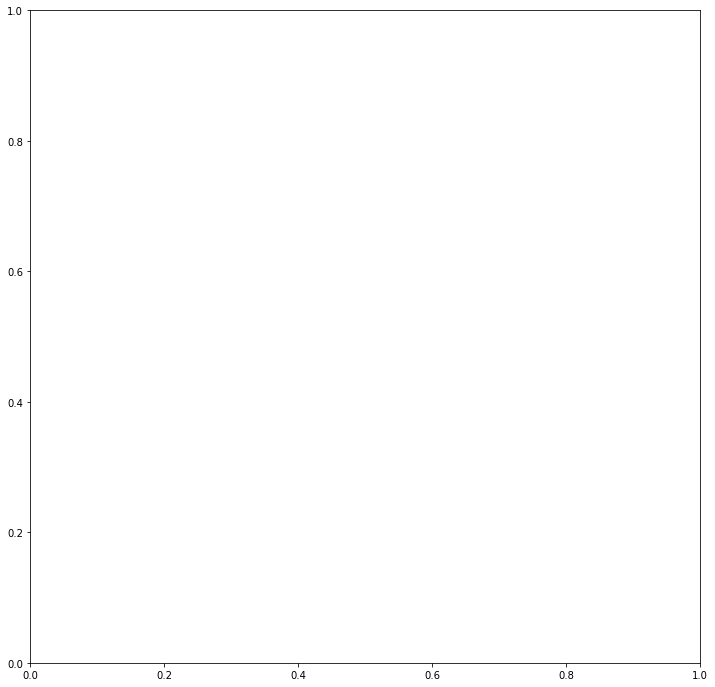

In [158]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(stack, X_test_vec, y_test, display_labels=['Republican', 'Democrat'], cmap='viridis', ax=ax)
plt.xticks(rotation=45)
plt.title('Confusion Matrix Stack Model', size=15)
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12)
plt.savefig('../visuals/tokens_confusion_matrix.png', bbox_inches='tight');

In [141]:
y_pred = stack.predict(X_test_vec)

In [142]:
# Inspiration https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro', zero_division=0)))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro', zero_division=0)))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted', zero_division=0)))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))


Accuracy: 0.78

Micro Precision: 0.78
Micro Recall: 0.78
Micro F1-score: 0.78

Macro Precision: 0.78
Macro Recall: 0.78
Macro F1-score: 0.78

Weighted Precision: 0.78
Weighted Recall: 0.78
Weighted F1-score: 0.78


In [143]:
X_test[(y_test != y_pred) & (y_pred == 0)]

4087     enjoyed meeting maitland fire chief kimberly n...
26254    great meeting today washington school board le...
29052    realdonaldtrump agree need suppo law enforceme...
5567     currently homeland security mmittee hearing ex...
23982                   happy alohafriday safe fun weekend
                               ...                        
36911    nothing says drain sw like telling room full b...
22385    nation celebrates mlkday honoring life  legacy...
2087     great meeting cal poly president cpprezarmstro...
32571     sylvesteurner evening nimitz hs jrotc celebra...
1592     must ensure america remains nation people back...
Name: tokens, Length: 2476, dtype: object

### Adding Bi-grams to above model

In [144]:
cvec_bg = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = 0.5, 
                                min_df = 10,
                                ngram_range=(2,2))

X_train_vec_bg= cvec_bg.fit_transform(X_train)
X_test_vec_bg = cvec_bg.transform(X_test)

In [145]:
# Using the same stacked model
cross_val_score(stack, X_train_vec_bg, y_train).mean()

# The mean of these scores is 0.6490546079999999

array([0.65055131, 0.64854653, 0.6417335 , 0.65484269, 0.64959901])

In [149]:
stack.fit(X_train_vec_bg, y_train);
stack.score(X_train_vec_bg, y_train), stack.score(X_test_vec_bg, y_test)

(0.7066870238425712, 0.6454314133703447)

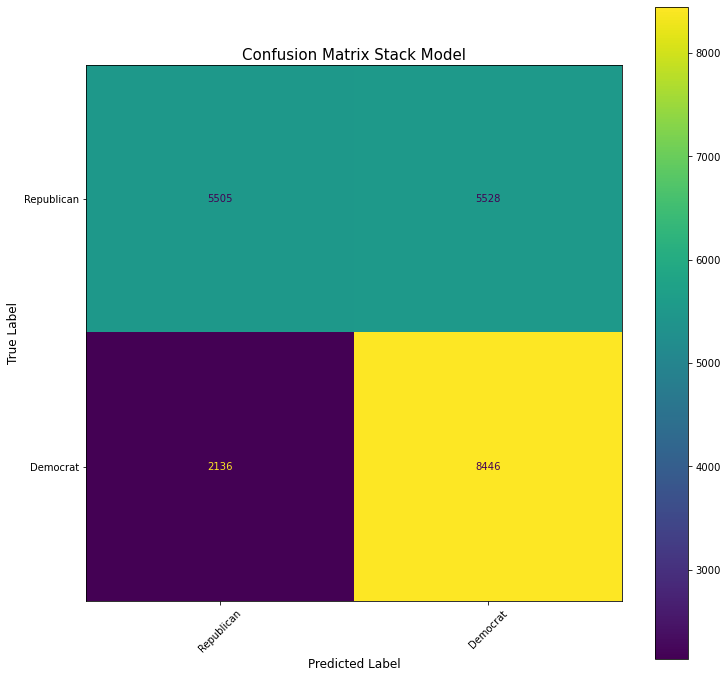

In [152]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(stack, X_test_vec_bg, y_test, display_labels=['Republican', 'Democrat'], cmap='viridis', ax=ax)
plt.xticks(rotation=45)
plt.title('Confusion Matrix Stack Model', size=15)
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12)
plt.savefig('../visuals/tokens_confusion_matrix_with_bigrams.png', bbox_inches='tight');



In [ ]:
y_pred_bg = stack.predict(X_test_vec_bg)

In [151]:
# Inspiration https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred_bg)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred_bg, average='micro', zero_division=0)))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred_bg, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred_bg, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred_bg, average='macro', zero_division=0)))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred_bg, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred_bg, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred_bg, average='weighted', zero_division=0)))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred_bg, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred_bg, average='weighted')))




Accuracy: 0.65

Micro Precision: 0.65
Micro Recall: 0.65
Micro F1-score: 0.65

Macro Precision: 0.66
Macro Recall: 0.65
Macro F1-score: 0.64

Weighted Precision: 0.66
Weighted Recall: 0.65
Weighted F1-score: 0.64


In [160]:
X_test[(y_test != y_pred_bg) & (y_pred_bg == 0)]

9673     apply pa summer intern class accepting applica...
4087     enjoyed meeting maitland fire chief kimberly n...
26254    great meeting today washington school board le...
29052    realdonaldtrump agree need suppo law enforceme...
7726     new law  authored rep david young iowa improve...
                               ...                        
2511     repmccaul benniegthompson danarohrabacher rep ...
37132     wishing everyone happy safe thanksgiving holiday
32275     govtrack benniegthompson medgar evers home na...
2087     great meeting cal poly president cpprezarmstro...
5658     privilege honor life service tique lee caul tr...
Name: tokens, Length: 2136, dtype: object

# Testing Tokens with Topic Models

In [10]:
X_lda = df_lda['tokens']
y_lda = df_lda['Party']

In [11]:
X_lda

0        today senate dems vote savetheinternet proud s...
1         winterhavensun winter resident alta vista tea...
2         nbclatino repdarrensoto noted hurricane maria...
3         nalcabpolicy meeting repdarrensoto thanks tak...
4         vegalteno hurricane season stas june 1st pueo...
                               ...                        
86456    check op ed need end executive overreach act w...
86457    yesterday betty  great time learning forestry ...
86458    forever grateful service sacrifice major barne...
86459      happy first day school bbschools bbbacktoschool
86460    zika fears realized florida house gop acted pr...
Name: tokens, Length: 86457, dtype: object

In [12]:
y_lda

0        1
1        1
2        1
3        1
4        1
        ..
86456    0
86457    0
86458    0
86459    0
86460    0
Name: Party, Length: 86457, dtype: int64

In [13]:
X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_lda, y_lda, random_state=42)

In [67]:
X_train_lda

12578     neiltyson passing left intellectual vacuum wa...
2311     womenshistorymonth thanks tb times regnizing a...
73791    illegal immigrants americans reluctant impo yo...
14945     ac360 democrat rep eric swalwell tells anders...
3180     firing deputy fbi director andrew mccabe frida...
                               ...                        
6265     virginia insurers directly blamed trump gop sa...
54890    breaking news ngress passed emergency relief f...
76824    prlatina44 repwebster repdennisross vanessa he...
860      era equal pay equal work much equality oppoun ...
15796    usgao listed extremeweather one pressing finan...
Name: tokens, Length: 64842, dtype: object

In [101]:
# Added bigrams here to try and improve the model. Going to do the same with the tokens only model above.
cvec = CountVectorizer(strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                token_pattern = r'\b[a-zA-Z]{3,}\b',
                                max_df = .5, 
                                min_df = 10,
                                ngram_range=(2,2))

X_train_lda_vec = cvec.fit_transform(X_train_lda)
X_test_lda_vec = cvec.transform(X_test_lda)

In [103]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=20, random_state=42) 
X_train_lda_vec = lda.fit_transform(X_train_lda_vec)
X_test_lda_vec = lda.transform(X_test_lda_vec)

In [104]:
# Checking to make sure y_train values are 1s and 0s
y_train_lda.value_counts()

0    33359
1    31483
Name: Party, dtype: int64

In [105]:
# Checking to make sure y_test values are 1s and 0s
y_test_lda.value_counts()

0    11033
1    10582
Name: Party, dtype: int64

In [106]:
# Checking X_train
X_train_lda_vec

array([[0.05      , 0.05      , 0.05      , ..., 0.05      , 0.05      ,
        0.05      ],
       [0.05      , 0.05      , 0.05      , ..., 0.05      , 0.05      ,
        0.05      ],
       [0.01666667, 0.01666667, 0.01666667, ..., 0.35      , 0.01666667,
        0.01666667],
       ...,
       [0.05      , 0.05      , 0.05      , ..., 0.05      , 0.05      ,
        0.05      ],
       [0.0125    , 0.0125    , 0.0125    , ..., 0.0125    , 0.0125    ,
        0.0125    ],
       [0.01666667, 0.01666667, 0.01666667, ..., 0.01666667, 0.01666667,
        0.01666667]])

In [107]:
# Checking X_test
X_test_lda_vec

array([[0.05      , 0.05      , 0.05      , ..., 0.05      , 0.05      ,
        0.05      ],
       [0.05      , 0.05      , 0.05      , ..., 0.05      , 0.05      ,
        0.05      ],
       [0.01666667, 0.01666667, 0.01666667, ..., 0.01666667, 0.01666667,
        0.01666667],
       ...,
       [0.025     , 0.025     , 0.025     , ..., 0.025     , 0.025     ,
        0.025     ],
       [0.025     , 0.025     , 0.025     , ..., 0.025     , 0.025     ,
        0.025     ],
       [0.05      , 0.05      , 0.05      , ..., 0.05      , 0.05      ,
        0.05      ]])

### Using the same stacked model as above

In [123]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import SGDClassifier

level_1_models = [         
    ('lr_pipe', Pipeline([
        ('lr', LogisticRegression(C=1, class_weight=None, penalty='l2', max_iter=10_000, solver='lbfgs'))
    ])),
    ('rf_pipe', Pipeline([
        ('rf', RandomForestClassifier(max_depth=None, min_samples_leaf=1, min_samples_split=4, n_estimators=200))
    ])),
    ('gb_pipe', Pipeline([
        ('gb', GradientBoostingClassifier(learning_rate=.4, max_depth=5, n_estimators=250))
    ])),
    ('sgdc_pipe', Pipeline([
        ('sgdc', SGDClassifier(max_iter=10_000, tol=1e-3, alpha=20, loss='modified_huber', class_weight='balanced'))
    ]))
]
    
stack_lda = StackingClassifier(estimators=level_1_models, final_estimator=LogisticRegression())

In [ ]:
#Initial cross_val_score was .58 with 20 topics
#Second test is with 10 topics.. with a cv score 0f .56
#Third attempt is with 30 topics.. with a cv score of .54
#Fourth attempt is with 20 topics, but introducing bi-grams..

In [124]:
cross_val_score(stack_lda, X_train_lda_vec, y_train_lda).mean()

0.5439683161797728

In [126]:
stack_lda.fit(X_train_lda_vec, y_train_lda);
stack_lda.score(X_train_lda_vec, y_train_lda), stack_lda.score(X_test_lda_vec, y_test_lda)

(0.5792233428950372, 0.547027527180199)

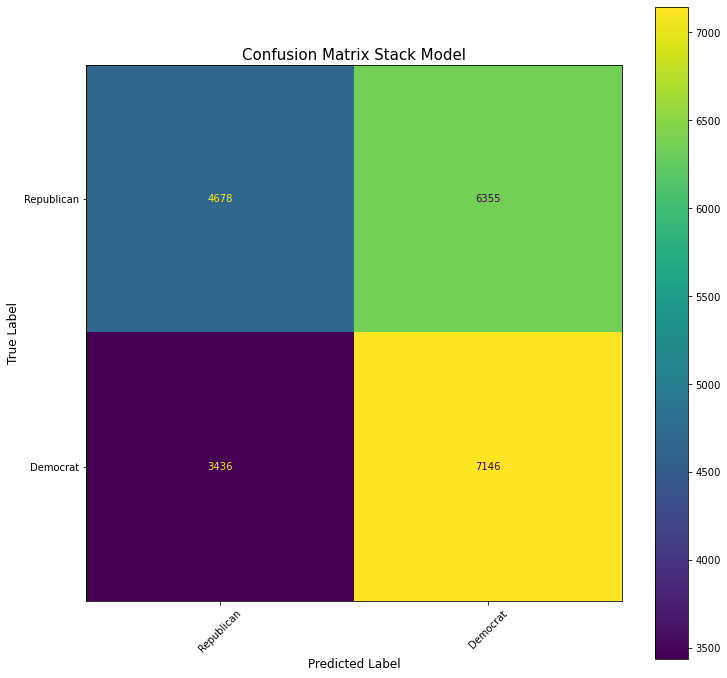

In [127]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(stack_lda, X_test_lda_vec, y_test_lda, display_labels=['Republican', 'Democrat'], cmap='viridis', ax=ax)
plt.xticks(rotation=45)
plt.title('Confusion Matrix Stack Model', size=15)
plt.xlabel('Predicted Label', size=12)
plt.ylabel('True Label', size=12)
plt.savefig('../visuals/LDA_confusion_matrix.png');

In [128]:
y_pred_lda = stack_lda.predict(X_test_lda_vec)

In [129]:
# Inspiration https://towardsdatascience.com/confusion-matrix-for-your-multi-class-machine-learning-model-ff9aa3bf7826
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test_lda, y_pred_lda)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_lda, y_pred_lda, average='micro', zero_division=0)))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_lda, y_pred_lda, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_lda, y_pred_lda, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_lda, y_pred_lda, average='macro', zero_division=0)))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_lda, y_pred_lda, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_lda, y_pred_lda, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_lda, y_pred_lda, average='weighted', zero_division=0)))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_lda, y_pred_lda, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_lda, y_pred_lda, average='weighted')))


Accuracy: 0.55

Micro Precision: 0.55
Micro Recall: 0.55
Micro F1-score: 0.55

Macro Precision: 0.55
Macro Recall: 0.55
Macro F1-score: 0.54

Weighted Precision: 0.55
Weighted Recall: 0.55
Weighted F1-score: 0.54


In [130]:
X_test_lda[(y_test_lda != y_pred_lda) & (y_pred_lda == 0)]

8074     yet another u struck realdonaldtrump healess e...
33093    father nroy done superb job tending flock spea...
15398     oversightdems repcummings president administr...
4087     enjoyed meeting maitland fire chief kimberly n...
26254    great meeting today washington school board le...
                               ...                        
2511     repmccaul benniegthompson danarohrabacher rep ...
19471     davidhogg111 speakerryan would please please ...
39476    sad leave office occupied decades glad see dea...
36444    ongoing power failures pueori remain unaccepta...
26593    house republicans say gopfarmbill kick single ...
Name: tokens, Length: 3436, dtype: object

# Attempting lda2vec

In [85]:
 # https://www.slideshare.net/ChristopherMoody3/word2vec-lda-and-introducing-a-new-hybrid-algorithm-lda2vec-57135994
    